In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

In [2]:
data = pd.read_csv("./datatraining.csv")

Набор данных содержит экспериментальные данные, используемые для бинарной классификации (занятость офисного помещения) по температуре, влажности, освещенности и CO2

In [3]:
data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2/2/2015 14:19,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2/2/2015 14:19,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2/2/2015 14:21,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2/2/2015 14:22,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2/2/2015 14:23,23.7540,26.200,488.600000,779.000000,0.004767,1


Набор данных имеет следующие признаки:

* Date - дата и время в формате год-месяц-день час:минута:секунда
* Temperature - температура в градусах Цельсия
* Humidity - относительная влажность в процентах
* Light - измерение освещенности в люксах
* CO2 - CO2 в частях на миллион (ppm)
* HumidityRatio - коэффициент влажности: производное количество от температуры и относительной влажности, в кг водяного пара/кг воздуха
* Occupancy - занято помещение или нет: 1 — занято, 0 — не занято

Все признаки кроме даты и целевой переменной имеют количественный тип

In [4]:
data.shape

(20560, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


Дата, очевидно, не несет полезной информации - уберем ее

In [6]:
data = data.drop('date', axis=1)

In [7]:
feature_cols = [
    'Temperature',
    'Humidity',
    'Light',
    'CO2',
    'HumidityRatio',
]

target_col = ['Occupancy']

In [8]:
data.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


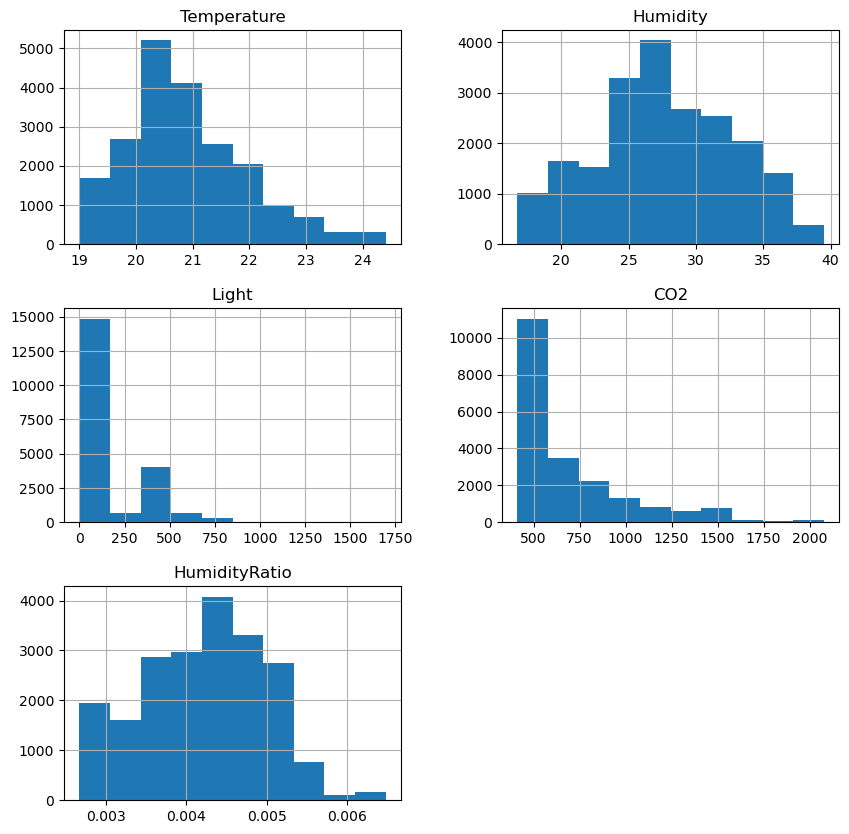

In [9]:
data.hist(column = feature_cols, figsize = (10,10));

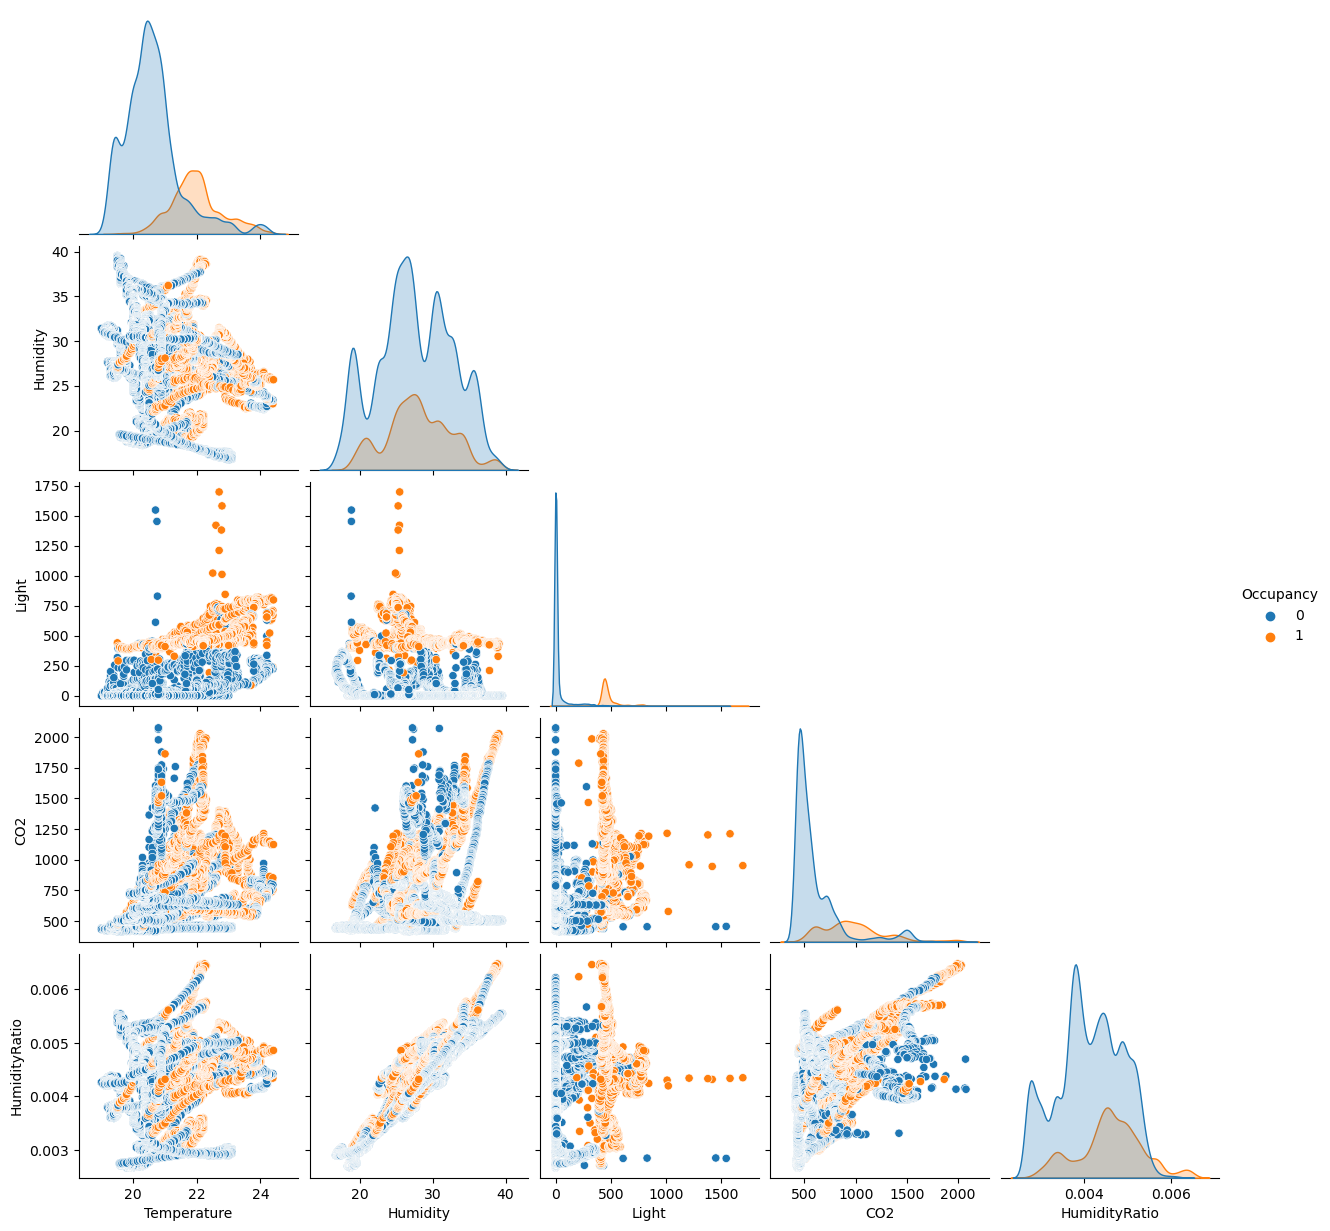

In [10]:
sns.pairplot(data, hue='Occupancy', corner=True);

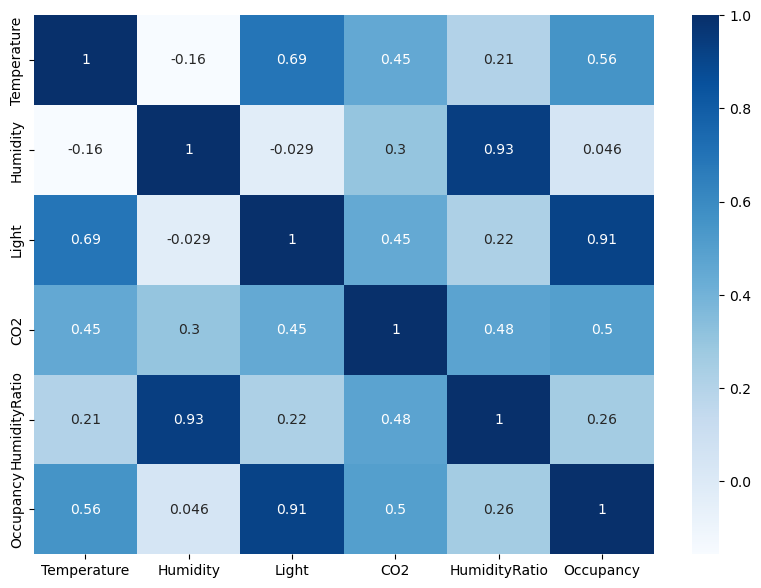

In [11]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(), cmap="Blues", annot=True);

Очевидно, что излишне иметь два признака, отвечающие за влажность, диаграмма это подтверждает. Из нее также видно, что признак влажности более коррелирован с присутствием объекта в комнате, чем коэффициент влажности, так что удаляем HumidityRatio. Также из диаграммы ясно видно, что наиболее коррелированным с присутствием в комнате является признак освещенности

In [12]:
data.drop(['HumidityRatio'], axis=1, inplace=True)
feature_cols.remove('HumidityRatio')

Изучим данные на предмет выбросов

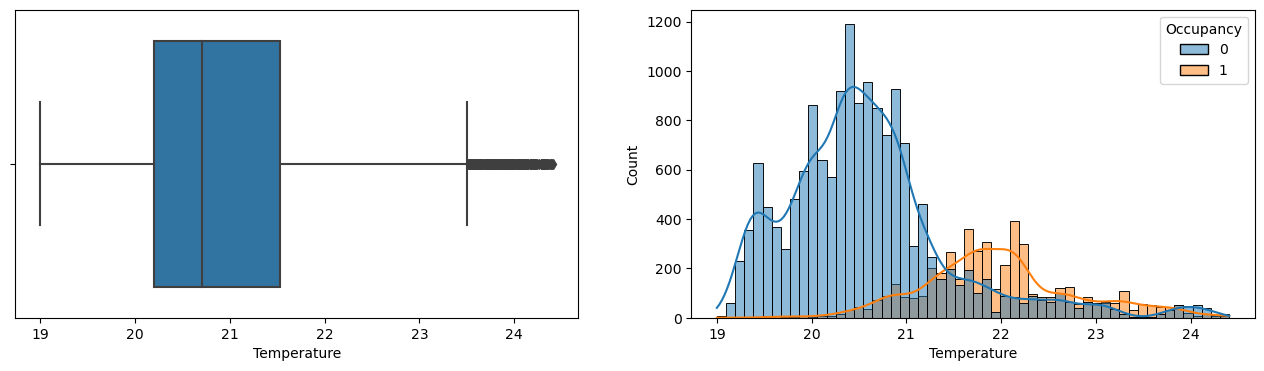

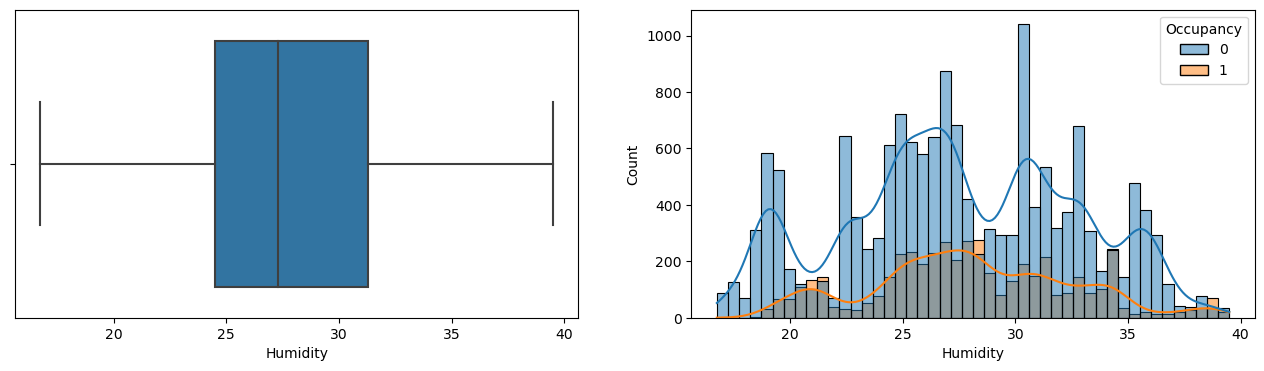

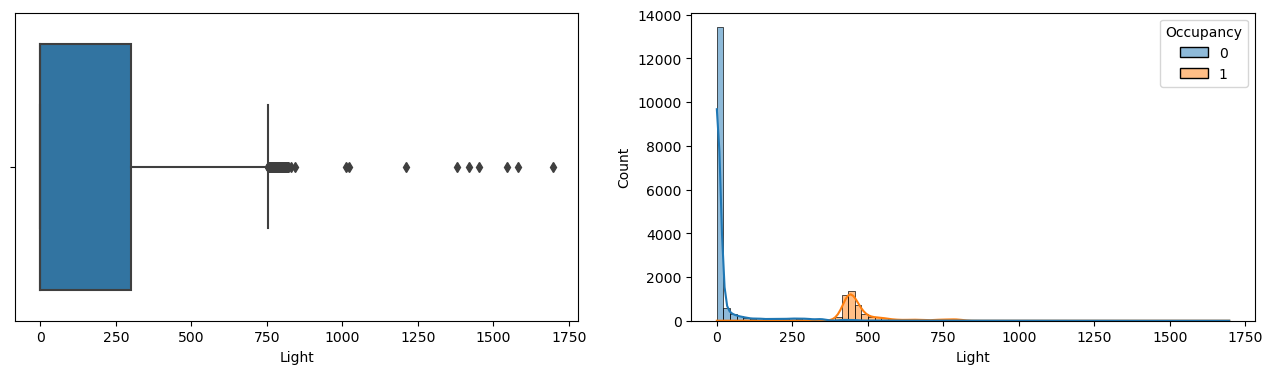

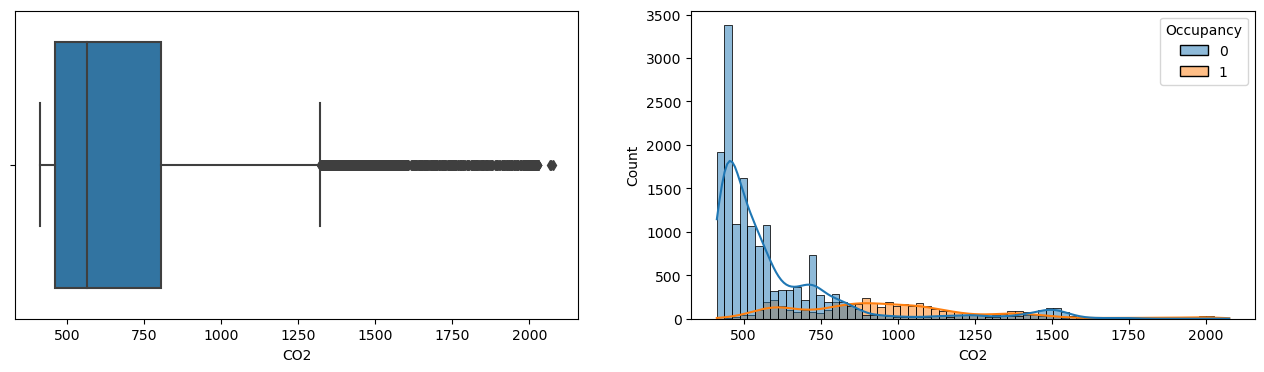

In [13]:
for c in feature_cols:
  fig, ax = plt.subplots(1, 2, figsize=(16, 4))
  sns.boxplot(x=data[c], ax=ax[0])
  sns.histplot(data=data[[c, 'Occupancy']], x=data[c], hue='Occupancy', ax=ax[1], kde=True);

Избавимся от записей со слишком высоким уровнем освещенности

In [14]:
rows_to_drop = data[(data['Light'] > data['Light'].quantile(0.995))].index
data = data.drop(rows_to_drop)

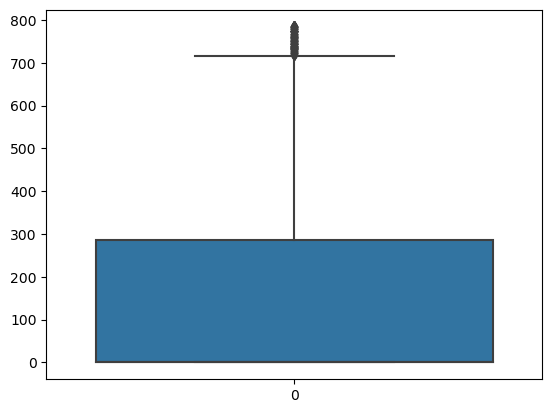

In [15]:
sns.boxplot(data=data['Light']);

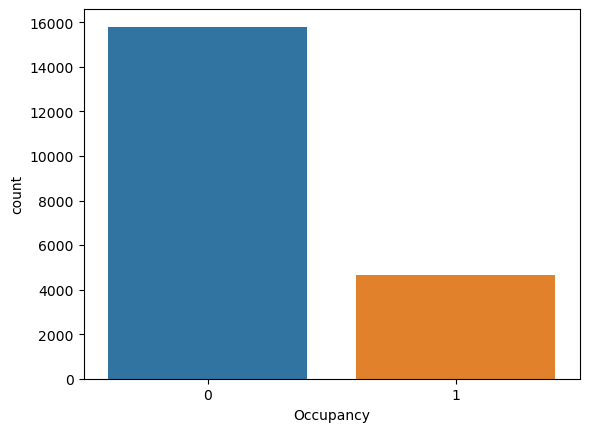

In [16]:
# посмотрим на распределение целевой переменной
ax = sns.countplot(x='Occupancy', data=data[target_col])

In [17]:
data[data[target_col] == 1].Occupancy.count()

4652

In [18]:
data[data[target_col] == 0].Occupancy.count()

15807

In [19]:
# видим, что данные сильно несбалансированы по таргету
# в дальнейшем для сбалансирования будем использовать оверсэмплинг, чтобы модель не училась только на нулевом таргете
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

In [20]:
X = data[feature_cols]
y = data[target_col]

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_train.shape, y_train.shape

((22130, 4), (22130, 1))

Стандартизируем признаки

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
def print_scores(grid_cv):
    print(f'Усреднённое качество на кроссвалидации при лучших гиперпараметрах: {grid_cv.best_score_:.3f}')
    print(f'Лучшие гиперпараметры: {grid_cv.best_params_}')
    print(f'Качество на трейне: {grid_cv.score(X_train_scaled, y_train):.3f}')
    print(f'Качество на отложенной выборке: {grid_cv.score(X_test_scaled, y_test):.3f}')

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [26]:
param_grid = {'n_neighbors': np.arange(1, 61, 5),
              'p': [1, 2],
              'weights': ['uniform', 'distance']}

knn_grid_cv = GridSearchCV(KNeighborsClassifier(),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           return_train_score=True)
knn_grid_cv.fit(X_train_scaled, y_train);

In [27]:
print_scores(knn_grid_cv)

Усреднённое качество на кроссвалидации при лучших гиперпараметрах: 0.999
Лучшие гиперпараметры: {'n_neighbors': 56, 'p': 1, 'weights': 'distance'}
Качество на трейне: 1.000
Качество на отложенной выборке: 0.999


In [28]:
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 30, 1)}

decision_tree_grid_cv = GridSearchCV(DecisionTreeClassifier(),
                                     param_grid=param_grid,
                                     scoring='roc_auc',
                                     n_jobs=-1,
                                     return_train_score=True)
decision_tree_grid_cv.fit(X_train_scaled, y_train);

In [29]:
print_scores(decision_tree_grid_cv)

Усреднённое качество на кроссвалидации при лучших гиперпараметрах: 0.997
Лучшие гиперпараметры: {'criterion': 'entropy', 'max_depth': 5}
Качество на трейне: 0.999
Качество на отложенной выборке: 0.994


In [30]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.0001, 0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}

log_reg_grid_cv = GridSearchCV(LogisticRegression(),
                               param_grid=param_grid,
                               scoring='roc_auc',
                               n_jobs=-1,
                               return_train_score=True)
log_reg_grid_cv.fit(X_train_scaled, y_train);

In [31]:
print_scores(log_reg_grid_cv)

Усреднённое качество на кроссвалидации при лучших гиперпараметрах: 0.995
Лучшие гиперпараметры: {'C': 0.01, 'penalty': 'l2'}
Качество на трейне: 0.995
Качество на отложенной выборке: 0.995


In [32]:
param_grid = {'kernel': ['sigmoid'],
              'C': [0.0001, 0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}

svc_grid_cv = GridSearchCV(SVC(),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           return_train_score=True)
svc_grid_cv.fit(X_train_scaled, y_train);

In [33]:
print_scores(svc_grid_cv)

Усреднённое качество на кроссвалидации при лучших гиперпараметрах: 0.992
Лучшие гиперпараметры: {'C': 0.001, 'kernel': 'sigmoid'}
Качество на трейне: 0.992
Качество на отложенной выборке: 0.991


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

y_pred = knn_grid_cv.predict(X_test_scaled)

In [35]:
accuracy_score(y_test, y_pred)

0.9900619094167481

In [36]:
precision_score(y_test, y_pred)

0.9619377162629758

In [37]:
recall_score(y_test, y_pred)

0.995702005730659

Таким образом, лучшее качество показывает метод ближайших соседей, практически идеально определяющий присутствие объекта в комнате. Самые полезные признаки - это уровень освещенности, температура и уровень углекислого газа